#### Preparativos

In [2]:
# Instalaciones
!pip install lightgbm

In [32]:
# Importaciones

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import lightgbm as lgb
from lightgbm import LGBMClassifier

import time
import joblib
import pickle

In [5]:
# Deslimitar/Limitar display Pandas

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', None)

#### Preparación del Dataset

In [6]:
df0 = pd.read_csv(r'D:\DEV\Python\00_TFM_PALLADIUM\02_DATASETS_GENERADOS\Reservas_Stacking.csv', sep=';')

In [7]:
df0.head()

,HOTEL,LLEGADA_MES,LLEGADA_DIAm,LLEGADA_DIAs,LLEGADA_AVANCE,SALIDA_MES,SALIDA_DIAm,SALIDA_DIAs,SALIDA_AVANCE,NOCHES,DURACION_ESTANCIA,REGIMEN,TIPO,USO,PAX_NUM,PAX_CAT,ADULTOS,NENES,BEBES,TIPO_CLIENTE,CLIENTE,GRUPO,MONEDA,SUPLETORIA,CUNAS,FECHA_TOMA_MES,FECHA_TOMA_DIAm,FECHA_TOMA_DIAs,FECHA_TOMA_AVANCE,LT_TOMA_LLEGADA,FIDELIDAD,COMERCIALIZADORA,VALOR_USD,VALOR_USD_PAX,VALOR_USD_NOCHE,VALOR_USD_PAX_NOCHE,GRATIS,PAIS,CONTINENTE,SEGMENTO,FUENTE_NEGOCIO,CANCELADA,TAMANO_HOTEL
0,GrandPalladiumJamaica&LadyHamiltonResort,12,28,3,0.989041,1,4,3,0.008219,7,Media,AllInclusive,LHAmbassadorSuiteBSOV,2,3,Familias,2,1,0,1,PALLADIUMTRAVELCLUB_SOCIOS,0,USD,0,0,1,13,4,0.032877,349,Ninguna,0,2576.00,858.666667,368.00,122.666667,0,ESTADOSUNIDOS,AMERICA,Fixedrates,DIRECTSALES,0,Mediano
1,GrandPalladiumJamaica&LadyHamiltonResort,1,22,6,0.057534,1,29,6,0.076712,7,Media,AllInclusive,LHJuniorSuiteGV,2,3,Familias,2,1,0,1,PALLADIUMTRAVELCLUB_SOCIOS,0,USD,0,0,7,13,2,0.528767,193,Ninguna,0,1994.30,664.766667,284.90,94.966667,0,ESTADOSUNIDOS,AMERICA,Fixedrates,DIRECTSALES,1,Mediano
2,ComplejoRivieraMaya,11,6,1,0.846575,11,14,2,0.868493,8,Media,AllInclusive,TRSJuniorSuitePS,2,2,Parejas,2,0,0,1,PALLADIUMTRAVELCLUB_SOCIOS,0,USD,0,0,4,17,1,0.290411,203,Ninguna,0,2305.60,1152.800000,288.20,144.100000,0,CANADA,AMERICA,Fixedrates,DIRECTSALES,1,Grande
3,ComplejoRivieraMaya,11,6,1,0.846575,11,23,4,0.893151,17,Larga,AllInclusive,TRSJuniorSuitePS,2,2,Parejas,2,0,0,1,PALLADIUMTRAVELCLUB_SOCIOS,0,USD,0,0,2,22,3,0.142466,257,Ninguna,0,4899.40,2449.700000,288.20,144.100000,0,ESTADOSUNIDOS,AMERICA,Fixedrates,DIRECTSALES,1,Grande
4,ComplejoRivieraMaya,11,25,6,0.898630,12,9,6,0.936986,14,Larga,AllInclusive,COLJuniorSuiteGV,1,1,Single,1,0,0,1,PALLADIUMTRAVELCLUB_SOCIOS,0,USD,0,0,2,17,5,0.128767,281,Ninguna,0,2435.02,2435.020000,173.93,173.930000,0,RUMANIA,EURESTE,Fixedrates,DIRECTSALES,1,Grande


In [8]:
# Reconfigurar dtypes

df0['HOTEL'] = df0['HOTEL'].astype('category', errors='raise')
df0['LLEGADA_MES'] = pd.to_numeric(df0['LLEGADA_MES'], errors='raise').astype('category')
df0['LLEGADA_DIAm'] = pd.to_numeric(df0['LLEGADA_DIAm'], errors='raise').astype('category')
df0['LLEGADA_DIAs'] = pd.to_numeric(df0['LLEGADA_DIAs'], errors='raise').astype('category')
df0['LLEGADA_AVANCE'] = pd.to_numeric(df0['LLEGADA_AVANCE'], errors='raise').astype(float)
df0['SALIDA_MES'] = pd.to_numeric(df0['SALIDA_MES'], errors='raise').astype('category')
df0['SALIDA_DIAm'] = pd.to_numeric(df0['SALIDA_DIAm'], errors='raise').astype('category')
df0['SALIDA_DIAs'] = pd.to_numeric(df0['SALIDA_DIAs'], errors='raise').astype('category')
df0['SALIDA_AVANCE'] = pd.to_numeric(df0['SALIDA_AVANCE'], errors='raise').astype(float)
df0['NOCHES'] = pd.to_numeric(df0['NOCHES'], errors='raise').astype('Int64')
df0['DURACION_ESTANCIA'] = df0['DURACION_ESTANCIA'].astype('category', errors='raise')
df0['REGIMEN'] = df0['REGIMEN'].astype('category', errors='raise')
df0['TIPO'] = df0['TIPO'].astype('category', errors='raise')
df0['USO'] = pd.to_numeric(df0['USO'], errors='raise').astype('Int64')
df0['PAX_NUM'] = pd.to_numeric(df0['PAX_NUM'], errors='raise').astype('Int64')
df0['PAX_CAT'] = df0['PAX_CAT'].astype('category', errors='raise')
df0['ADULTOS'] = pd.to_numeric(df0['ADULTOS'], errors='raise').astype('Int64')
df0['NENES'] = pd.to_numeric(df0['NENES'], errors='raise').astype('Int64')
df0['BEBES'] = pd.to_numeric(df0['BEBES'], errors='raise').astype('Int64')
df0['TIPO_CLIENTE'] = pd.to_numeric(df0['TIPO_CLIENTE'], errors='raise').astype('category')
df0['CLIENTE'] = df0['CLIENTE'].astype('category', errors='raise')
df0['GRUPO'] = pd.to_numeric(df0['GRUPO'], errors='raise').astype('category')
df0['MONEDA'] = df0['MONEDA'].astype('category', errors='raise')
df0['SUPLETORIA'] = pd.to_numeric(df0['SUPLETORIA'], errors='raise').astype('Int64')
df0['CUNAS'] = pd.to_numeric(df0['CUNAS'], errors='raise').astype('Int64')
df0['FECHA_TOMA_MES'] = pd.to_numeric(df0['FECHA_TOMA_MES'], errors='raise').astype('category')
df0['FECHA_TOMA_DIAm'] = pd.to_numeric(df0['FECHA_TOMA_DIAm'], errors='raise').astype('category')
df0['FECHA_TOMA_DIAs'] = pd.to_numeric(df0['FECHA_TOMA_DIAs'], errors='raise').astype('category')
df0['FECHA_TOMA_AVANCE'] = pd.to_numeric(df0['FECHA_TOMA_AVANCE'], errors='raise').astype(float)
df0['LT_TOMA_LLEGADA'] = pd.to_numeric(df0['LT_TOMA_LLEGADA'], errors='raise').astype('Int64')
df0['FIDELIDAD'] = df0['FIDELIDAD'].astype('category', errors='raise')
df0['COMERCIALIZADORA'] = pd.to_numeric(df0['COMERCIALIZADORA'], errors='raise').astype('category')
df0['VALOR_USD'] = pd.to_numeric(df0['VALOR_USD'], errors='raise').astype(float)
df0['VALOR_USD_PAX'] = pd.to_numeric(df0['VALOR_USD_PAX'], errors='raise').astype(float)
df0['VALOR_USD_NOCHE'] = pd.to_numeric(df0['VALOR_USD_NOCHE'], errors='raise').astype(float)
df0['VALOR_USD_PAX_NOCHE'] = pd.to_numeric(df0['VALOR_USD_PAX_NOCHE'], errors='raise').astype(float)
df0['GRATIS'] = pd.to_numeric(df0['GRATIS'], errors='raise').astype('category')
df0['PAIS'] = df0['PAIS'].astype('category', errors='raise')
df0['CONTINENTE'] = df0['CONTINENTE'].astype('category', errors='raise')
df0['SEGMENTO'] = df0['SEGMENTO'].astype('category', errors='raise')
df0['FUENTE_NEGOCIO'] = df0['FUENTE_NEGOCIO'].astype('category', errors='raise')
df0['CANCELADA'] = pd.to_numeric(df0['CANCELADA'], errors='raise').astype('category')
df0['TAMANO_HOTEL'] = df0['TAMANO_HOTEL'].astype('category', errors='raise')

In [9]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1139289 entries, 0 to 1139288
Data columns (total 43 columns):
 #   Column               Non-Null Count    Dtype   
---  ------               --------------    -----   
 0   HOTEL                1139289 non-null  category
 1   LLEGADA_MES          1139289 non-null  category
 2   LLEGADA_DIAm         1139289 non-null  category
 3   LLEGADA_DIAs         1139289 non-null  category
 4   LLEGADA_AVANCE       1139289 non-null  float64 
 5   SALIDA_MES           1139289 non-null  category
 6   SALIDA_DIAm          1139289 non-null  category
 7   SALIDA_DIAs          1139289 non-null  category
 8   SALIDA_AVANCE        1139289 non-null  float64 
 9   NOCHES               1139289 non-null  Int64   
 10  DURACION_ESTANCIA    1139289 non-null  category
 11  REGIMEN              1139289 non-null  category
 12  TIPO                 1139289 non-null  category
 13  USO                  1139289 non-null  Int64   
 14  PAX_NUM              1139289 non-n

#### Segmentación por TAMANO_HOTEL

In [10]:
# Antes de nada separamos DF para los 3 entrenamientos y optimizaciones distintas
# Luego, separamos sus train y test, para no tocar los tests para absolutamente nada salgo evaluar

df_G = df0.loc[df0['TAMANO_HOTEL'] == 'Grande']
df_M = df0.loc[df0['TAMANO_HOTEL'] == 'Mediano']
df_P = df0.loc[df0['TAMANO_HOTEL'] == 'Pequeno']

X_G = df_G.drop(columns=["CANCELADA","TAMANO_HOTEL"])
y_G = df_G["CANCELADA"]
X_G_train, X_G_test, y_G_train, y_G_test = train_test_split(X_G, y_G, test_size=0.2, random_state=42)

X_M = df_M.drop(columns=["CANCELADA","TAMANO_HOTEL"])
y_M = df_M["CANCELADA"]
X_M_train, X_M_test, y_M_train, y_M_test = train_test_split(X_M, y_M, test_size=0.2, random_state=42)

X_P = df_P.drop(columns=["CANCELADA","TAMANO_HOTEL"])
y_P = df_P["CANCELADA"]
X_P_train, X_P_test, y_P_train, y_P_test = train_test_split(X_P, y_P, test_size=0.2, random_state=42)

#### Común Modelos

In [11]:
# Preparación de la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#### Modelo Grande

In [12]:
# La optimización de hiperparámetros en bucle se ha hecho imposible por el gran tamaño del dataset y las limitaciones temporales y de HW
# Se han ido explorando hiperparámetros cambiando uno cada vez hasta llegar a un punto de optimización moderada, eso sí, siempre con validación cruzada de 5 KF
# Se perseguirá la mayor accuracy en test posible, la gran accuracy en train no deberá alarmarnos si la primera mejora. Además, con la VC no debería suponer problemas de generalización
# Se incluye sólo la última versión de cada modelo

In [13]:
# Objetivo a mejorar, la accuracy del modelo general sólo para estos hoteles
# Que fue de un 0.824905347 (Obtenido con subtotales en Excel)

In [14]:
# v12

modelo_lgbm_Grande = LGBMClassifier(
    objective = 'binary',
    random_state=42,
)

param_grid_lgbm_Grande = {
    'n_estimators': [15000],
    'max_depth': [25],
    'learning_rate': [0.25],
    'num_leaves': [75],
    'reg_alpha': [0.5],
    'reg_lambda': [0.5],
}

grid_search_lgbm_Grande = GridSearchCV(
    estimator=modelo_lgbm_Grande,
    param_grid=param_grid_lgbm_Grande,
    cv=kf,
    scoring="accuracy",
    n_jobs=-1,
    verbose=3,
    )

grid_search_lgbm_Grande.fit(X_G_train, y_G_train)
print(f"Best HyperParameters: {grid_search_lgbm_Grande.best_params_}")

# Asignar mejor estimador al modelo
modelo_lgbm_Grande = grid_search_lgbm_Grande.best_estimator_

# Resultados sobre test
y_G_test_pred = modelo_lgbm_Grande.predict(X_G_test)
accuracy_test = accuracy_score(y_G_test, y_G_test_pred)
print("Accuracy Test     :", accuracy_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 200036, number of negative: 339623
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2883
[LightGBM] [Info] Number of data points in the train set: 539659, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370671 -> initscore=-0.529339
[LightGBM] [Info] Start training from score -0.529339
Best HyperParameters: {'learning_rate': 0.25, 'max_depth': 25, 'n_estimators': 15000, 'num_leaves': 75, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
Accuracy

In [15]:
# Definición de función comprobadora del uso de hiperparámetros:

def get_tree_stats(tree, depth=0):
    # Si es una hoja
    if 'left_child' not in tree and 'right_child' not in tree:
        return depth, 1  # profundidad, 1 hoja

    # Recursión sobre hijos
    left_depth, left_leaves = get_tree_stats(tree['left_child'], depth + 1) if 'left_child' in tree else (depth, 0)
    right_depth, right_leaves = get_tree_stats(tree['right_child'], depth + 1) if 'right_child' in tree else (depth, 0)

    max_depth = max(left_depth, right_depth)
    total_leaves = left_leaves + right_leaves

    return max_depth, total_leaves

In [16]:
# Extraer todos los árboles
trees = modelo_lgbm_Grande.booster_.dump_model()['tree_info']

# Calcular profundidad y hojas de cada árbol
depths = []
leaves = []
for tree in trees:
    depth, num_leaves = get_tree_stats(tree['tree_structure'])
    depths.append(depth)
    leaves.append(num_leaves)

# Reporte
print(f"Número total de árboles             : {len(trees)}")
print(f"Profundidad máxima real alcanzada   : {max(depths)}")
print(f"Profundidad promedio de los árboles : {sum(depths) / len(depths):.2f}")
print(f"Máximo número de hojas en un árbol  : {max(leaves)}")
print(f"Promedio de hojas por árbol         : {sum(leaves) / len(leaves):.2f}")

Número total de árboles             : 15000
Profundidad máxima real alcanzada   : 21
Profundidad promedio de los árboles : 12.90
Máximo número de hojas en un árbol  : 75
Promedio de hojas por árbol         : 75.00


In [17]:
# Mirar pred de una línea, no sea que no pueda correr en tiempo real
# Ideal <10ms
# Máximo 100ms
# (16ms, estamos muy cerca del ideal)

tiempos = []

for i in range(len(X_G_test.head(1000))):
    fila = X_G_test.iloc[[i]]
    start = time.time()
    _ = modelo_lgbm_Grande.predict(fila)
    tiempos.append(time.time() - start)

tiempo_medio = sum(tiempos) / len(tiempos)
print(f"Tiempo medio por fila: {tiempo_medio * 1000:.3f} ms")

Tiempo medio por fila: 20.654 ms


#### Modelo Mediano

In [18]:
# Objetivo a mejorar, la accuracy del modelo general sólo para estos hoteles
# Que fue de un 0.786880037 (Obtenido con subtotales en Excel)

In [19]:
# v9
modelo_lgbm_Mediano = LGBMClassifier(
    random_state=42,
)

param_grid_lgbm_Mediano = {
    'n_estimators': [15000],
    'max_depth': [25],
    'learning_rate': [0.15],
    'num_leaves': [50],
}

grid_search_lgbm_Mediano = GridSearchCV(
    estimator=modelo_lgbm_Mediano,
    param_grid=param_grid_lgbm_Mediano,
    cv=kf,
    scoring="accuracy",
    n_jobs=-1,
    verbose=3,
    )

grid_search_lgbm_Mediano.fit(X_M_train, y_M_train)
print(f"Best HyperParameters: {grid_search_lgbm_Mediano.best_params_}")

# Asignar mejor estimador al modelo
modelo_lgbm_Mediano = grid_search_lgbm_Mediano.best_estimator_

# Resultados sobre test
y_M_test_pred = modelo_lgbm_Mediano.predict(X_M_test)
accuracy_test = accuracy_score(y_M_test, y_M_test_pred)
print("Accuracy Test     :", accuracy_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Number of positive: 131145, number of negative: 183892
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 315037, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.416284 -> initscore=-0.338045
[LightGBM] [Info] Start training from score -0.338045
Best HyperParameters: {'learning_rate': 0.15, 'max_depth': 25, 'n_estimators': 15000, 'num_leaves': 50}
Accuracy Test     : 0.7997714575926866


In [20]:
# Extraer todos los árboles
trees = modelo_lgbm_Mediano.booster_.dump_model()['tree_info']

# Calcular profundidad y hojas de cada árbol
depths = []
leaves = []
for tree in trees:
    depth, num_leaves = get_tree_stats(tree['tree_structure'])
    depths.append(depth)
    leaves.append(num_leaves)

# Reporte
print(f"Número total de árboles             : {len(trees)}")
print(f"Profundidad máxima real alcanzada   : {max(depths)}")
print(f"Profundidad promedio de los árboles : {sum(depths) / len(depths):.2f}")
print(f"Máximo número de hojas en un árbol  : {max(leaves)}")
print(f"Promedio de hojas por árbol         : {sum(leaves) / len(leaves):.2f}")

Número total de árboles             : 15000
Profundidad máxima real alcanzada   : 25
Profundidad promedio de los árboles : 12.92
Máximo número de hojas en un árbol  : 50
Promedio de hojas por árbol         : 50.00


#### Pequeño

In [21]:
# Objetivo a mejorar, la accuracy del modelo general sólo para estos hoteles
# Que fue de un 0.86248857 (Obtenido con subtotales en Excel)

In [22]:
# v10
modelo_lgbm_Pequeno = LGBMClassifier(
    random_state=42,
)

param_grid_lgbm_Pequeno = {
    'n_estimators': [15000],
    'max_depth': [30],
    'learning_rate': [0.2],
    'num_leaves': [50],
}

grid_search_lgbm_Pequeno = GridSearchCV(
    estimator=modelo_lgbm_Pequeno,
    param_grid=param_grid_lgbm_Pequeno,
    cv=kf,
    scoring="accuracy",
    n_jobs=-1,
    verbose=3,
    )

grid_search_lgbm_Pequeno.fit(X_P_train, y_P_train)
print(f"Best HyperParameters: {grid_search_lgbm_Pequeno.best_params_}")

# Asignar mejor estimador al modelo
modelo_lgbm_Pequeno = grid_search_lgbm_Pequeno.best_estimator_

# Resultados sobre test
y_P_test_pred = modelo_lgbm_Pequeno.predict(X_P_test)
accuracy_test = accuracy_score(y_P_test, y_P_test_pred)
print("Accuracy Test     :", accuracy_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Number of positive: 15434, number of negative: 41300
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2705
[LightGBM] [Info] Number of data points in the train set: 56734, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.272041 -> initscore=-0.984290
[LightGBM] [Info] Start training from score -0.984290
Best HyperParameters: {'learning_rate': 0.2, 'max_depth': 30, 'n_estimators': 15000, 'num_leaves': 50}
Accuracy Test     : 0.8678087986463621


In [23]:
# Extraer todos los árboles
trees = modelo_lgbm_Pequeno.booster_.dump_model()['tree_info']

# Calcular profundidad y hojas de cada árbol
depths = []
leaves = []
for tree in trees:
    depth, num_leaves = get_tree_stats(tree['tree_structure'])
    depths.append(depth)
    leaves.append(num_leaves)

# Reporte
print(f"Número total de árboles             : {len(trees)}")
print(f"Profundidad máxima real alcanzada   : {max(depths)}")
print(f"Profundidad promedio de los árboles : {sum(depths) / len(depths):.2f}")
print(f"Máximo número de hojas en un árbol  : {max(leaves)}")
print(f"Promedio de hojas por árbol         : {sum(leaves) / len(leaves):.2f}")

Número total de árboles             : 15000
Profundidad máxima real alcanzada   : 29
Profundidad promedio de los árboles : 14.26
Máximo número de hojas en un árbol  : 50
Promedio de hojas por árbol         : 50.00


#### Añadir predicciones a los DFs de test

In [24]:
# Hemos superado al moelo único para todo el dataset?df_G_test['ACIERTO'].mean()
# Su accuracy era de 0.8141210754066129

In [25]:
df_G_test = X_G_test.copy()
df_G_test['CANCELADA'] = y_G_test
df_G_test['CANCELADA_PRED'] = y_G_test_pred
df_G_test['ACIERTO'] = (df_G_test['CANCELADA'] == df_G_test['CANCELADA_PRED']).astype(int)

In [26]:
df_M_test = X_M_test.copy()
df_M_test['CANCELADA'] = y_M_test
df_M_test['CANCELADA_PRED'] = y_M_test_pred
df_M_test['ACIERTO'] = (df_M_test['CANCELADA'] == df_M_test['CANCELADA_PRED']).astype(int)

In [27]:
df_P_test = X_P_test.copy()
df_P_test['CANCELADA'] = y_P_test
df_P_test['CANCELADA_PRED'] = y_P_test_pred
df_P_test['ACIERTO'] = (df_P_test['CANCELADA'] == df_P_test['CANCELADA_PRED']).astype(int)

In [28]:
df_test = pd.concat([df_G_test, df_M_test, df_P_test], axis=0)

In [29]:
df_test['ACIERTO'].mean()

np.float64(0.8225393774220022)

successes = 187423


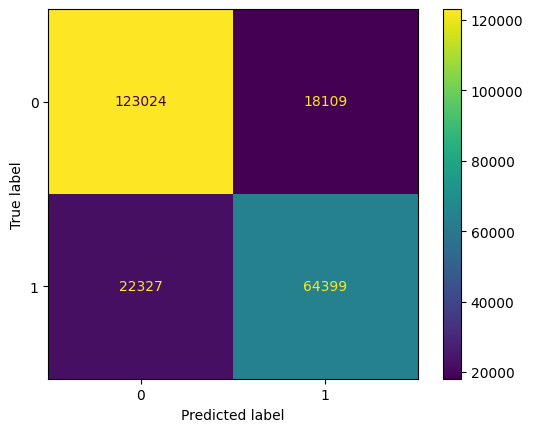

In [30]:
# Matriz de confusión en Test
cm = confusion_matrix(df_test['CANCELADA'], df_test['CANCELADA_PRED'], labels=np.unique(df_test['CANCELADA']))
print(f'successes = {np.trace(cm)}')
ConfusionMatrixDisplay.from_predictions(df_test['CANCELADA'], df_test['CANCELADA_PRED'], labels=np.unique(df_test['CANCELADA']))

In [ ]:
#df_test.to_csv(r'D:\DEV\Python\00_TFM_PALLADIUM\02_DATASETS_GENERADOS\Resultados_test_3stack.csv', index=False, sep=';')

#### Pickles

In [ ]:
# Cómo usar:

# Guardar el mejor modelo directamente
#with open("modelo_lgbm_Grande.pkl", "wb") as f:
#    pickle.dump(modelo_lgbm_Grande, f)

# Luego para cargarlo:
#with open("modelo_lgbm_Grande.pkl", "rb") as f:
#    modelo_lgbm_Grande = pickle.load(f)

# Predecir
#y_pred = modelo_lgbm_Grande.predict(X_test)

In [34]:
with open("modelo_lgbm_Grande.pkl", "wb") as f:
    pickle.dump(modelo_lgbm_Grande, f)

with open("modelo_lgbm_Mediano.pkl", "wb") as f:
    pickle.dump(modelo_lgbm_Mediano, f)

with open("modelo_lgbm_Pequeno.pkl", "wb") as f:
    pickle.dump(modelo_lgbm_Pequeno, f)

#### Pendiente

In [35]:
# SHAP con modelo general
    # SAHP Con estos 3 submodelos?

# Hacer un dataset combinado estos resultados y los del modelo global

In [36]:
# La mejora en estos casos es asintótica, por lo que necesitaremos cada vez más tiempo, esfuerzo y cómputo para lograr mejoras menores
# Creemos que la accuracy en test que tenemos es suficiente para un proyecto como el que tenemos entre manos y empieza a limitar la incertidumbre humana de cada huésped
# Con lo cual, guardaremos los mejores modelos en pickles para la puesta en producción... Pero:
# La idea es meterlo en un pickle para luego con él hacer el streamlit
    # Refitteo al dataset completo? (dentro de la segmentación "Grande")
        # Por ahora están fitteados al train, con la idea de usar filas concretas para el streamlit y ver que funciona.
        # Con datos nuevos o al tuntún sería un brindis al sol
        # Y de paso nos ahorramos horas de entrenamiento